# Image Classification via Transfer Learning:

> <small>hosein.mohebbi75@gmail.com</small> <br>


In this project, a small subset of the <a href="http://www.image-net.org/">ImageNet</a> has been used as a dataset. Three classes of Piano, Saxophone, and Violin, the number of images per class is limited to 600 images.

In the feature learning phase, the images are fed to a pre-trained Densely Connected Convolutional Networks (<a href="http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf">DenseNet</a>)-proposed by G Huang and et al in CVPR 2017- that top layer was removed and all convolutional layers have been frozen. 

Finally, both Support Vector Machine (SVM) and Fully Connected (FC) classifiers have been used to classify the extracted features and the results have been reported.

For SVM, t-distributed stochastic neighbor embedding (t-SNE) and Principal Component Analysis (PCA) have been used to transform features into a 2-d and 3-d feature space. For FC, all convolutional DenseNet layers have been frozen and only top layers (FC) have been trained.


In [0]:
from google.colab import drive
import os
import numpy as np
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
g_dir = '/content/gdrive/My\ Drive/Dataset'
!unzip $g_dir/ImageNet/ImageNet.zip > /dev/null
dataset_dir = 'ImageNet'
!ls $dataset_dir

grand_piano  sax  violin


### Loading Dataset

In [0]:
def loadImages(data_dir):
  data = {}
  for c in ['grand_piano', 'sax', 'violin']:
    data[c] = []
    if c == 'grand_piano':
      label = 0
    elif c == 'sax':
      label = 1
    elif c == 'violin':
      label = 2

    files = os.listdir(data_dir + '/' + c)
    files = files[0:600] # Maximum number objects for each class

    print("A sample object from {} class:".format(c))
    plt.imshow(image.load_img(data_dir + '/' + c + '/' + files[4], target_size=(224, 224)))
    plt.show()

    for f_name in files:
      img_path = data_dir + '/' + c + '/' + f_name

      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      data[c].append([x, label])
  
  return data

A sample object from grand_piano class:


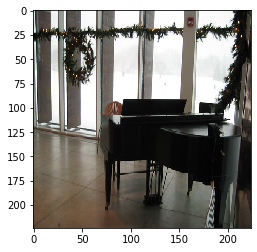

A sample object from sax class:


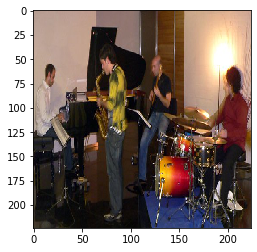

A sample object from violin class:


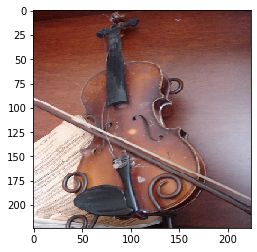

In [0]:
data = loadImages(dataset_dir)

### Spliting data into Train and Test (Validation) set

In [0]:
train_classObj1, test_classObj1 = train_test_split(data['grand_piano'], test_size = 0.25)
train_classObj2, test_classObj2 = train_test_split(data['sax'], test_size = 0.25)
train_classObj3, test_classObj3 = train_test_split(data['violin'], test_size = 0.25)

In [0]:
print("The number of TRAIN objects in each class: ", len(train_classObj1))
print("The number of TEST objects in each class: ", len(test_classObj1))

The number of TRAIN objects in each class:  450
The number of TEST objects in each class:  150


In [0]:
train_objs = train_classObj1 + train_classObj2 + train_classObj3
test_objs = test_classObj1 + test_classObj2 + test_classObj3

In [0]:
train_data = [x[0] for x in train_objs]
train_label = [y[1] for y in train_objs]

test_data = [x[0] for x in test_objs]
test_label = [y[1] for y in test_objs]

Compatible input dimension to feed into DenseNet mode in single mode to convert images to features for SVM

In [0]:
X_train = np.array(train_data)
X_test = np.array(test_data)

Compatible input dimension for fed into DenseNet Architecture in batch mode

In [0]:
train_data = np.squeeze(X_train)
train_label = np.array(train_label)

test_data = np.squeeze(X_test)
test_label = np.array(test_label)

In [0]:
print("Input dimension: ", train_data.shape)

Input dimension:  (1350, 224, 224, 3)


### Pre-trained DenseNet Model

In [0]:
base_model = DenseNet121(weights='imagenet', include_top=False)

# SVM approach

Converting images to fetures

In [0]:
training_feature = [base_model.predict(x).flatten() for x in X_train]
test_feature = [base_model.predict(x).flatten() for x in X_test]

In [0]:
training_feature = np.array(training_feature)
test_feature = np.array(test_feature)

In [0]:
print("Training feature dimension: ", training_feature.shape)
print("Test feature dimension: ", test_feature.shape)

Training feature dimension:  (1350, 50176)
Test feature dimension:  (450, 50176)


# Dimensionality reduction

t-SNE is not like PCA which has both fit and transform functions to fit train data and then transform the test data in new Coordinates.
But in t-SNE for test data, we need to run t-SNE again. On the other hand, t-SNE, unlike PCA, will work differently with each run even with the same parameters.
So to use the t-SNE here, I combined the training and test data and run the t-SNE on them and then split them again.(This approach is just for a test and is not acceptable in real world. In real world t-SNE is usually used for the visualization of high-dimensional datasets)

In [0]:
# t-SNE
tsne_2D = TSNE(n_components=2, perplexity=50, n_iter=1000, learning_rate=200, n_iter_without_progress = 10).fit_transform(np.concatenate((training_feature, test_feature)))
training_feature_tsne_2D = tsne_2D[0:1350,:]
test_feature_tsne_2D = tsne_2D[1350:1800,:]

tsne_3D = TSNE(n_components=3, perplexity=100, n_iter=1000, learning_rate=200, n_iter_without_progress = 10).fit_transform(np.concatenate((training_feature, test_feature)))
training_feature_tsne_3D = tsne_3D[0:1350,:]
test_feature_tsne_3D = tsne_3D[1350:1800,:]


# PCA
pca = PCA(n_components=2)
training_feature_pca_2D = pca.fit_transform(training_feature)
test_feature_pca_2D = pca.transform(test_feature)

pca = PCA(n_components=3)
training_feature_pca_3D = pca.fit_transform(training_feature)
test_feature_pca_3D = pca.transform(test_feature)

### Visualizing class objects in feature space

# t-SNE 2D

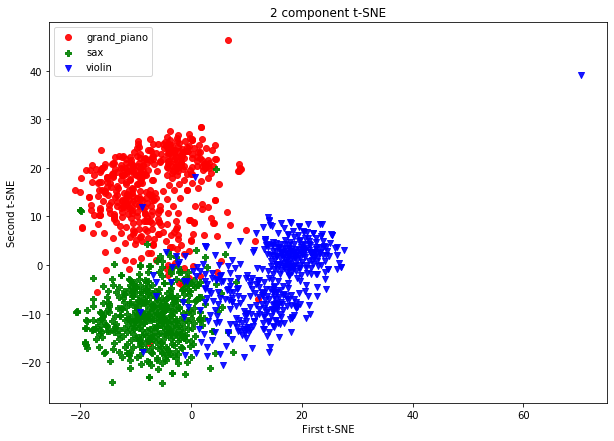

In [0]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = ['r', 'g', 'b']
markers = ['o', 'P', 'v']
classes = np.sort(np.unique(train_label))
labels = ['grand_piano', 'sax', 'violin']

for class_ix, marker, color, label in zip(classes, markers, colors, labels):
  ax.scatter(training_feature_tsne_2D[np.where(train_label == class_ix), 0],
             training_feature_tsne_2D[np.where(train_label == class_ix), 1],
             marker=marker, color=color,
             linewidth='1', alpha=0.9, label=label)
  ax.legend(loc='best')
plt.xlabel('First t-SNE')
plt.ylabel('Second t-SNE')
plt.title("2 component t-SNE")
plt.show()

# t-SNE 3D

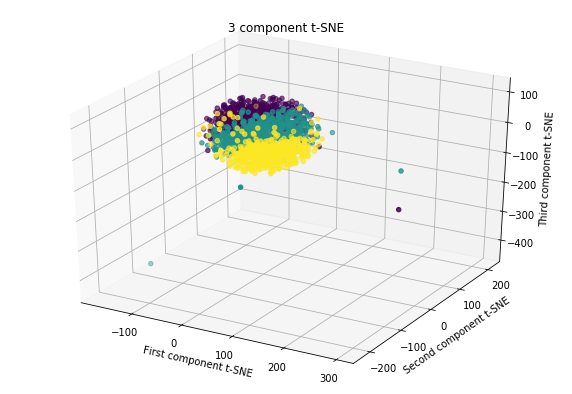

In [0]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b']
markers = ['o', 'P', 'v']
classes = np.sort(np.unique(train_label))
labels = ['grand_piano', 'sax', 'violin']

ax.scatter(training_feature_tsne_3D[:, 0],
             training_feature_tsne_3D[:, 1],
             training_feature_tsne_3D[:, 2],
             c=train_label)

ax.set_xlabel('First component t-SNE')
ax.set_ylabel('Second component t-SNE')
ax.set_zlabel('Third component t-SNE')
plt.title("3 component t-SNE")
plt.show()

# PCA 2D

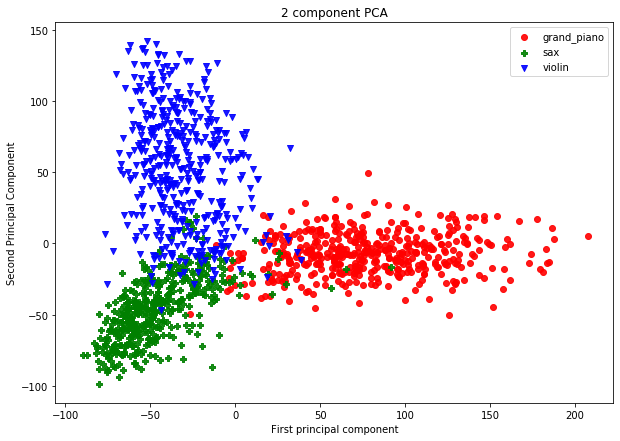

In [0]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = ['r', 'g', 'b']
markers = ['o', 'P', 'v']
classes = np.sort(np.unique(train_label))
labels = ['grand_piano', 'sax', 'violin']

for class_ix, marker, color, label in zip(classes, markers, colors, labels):
  ax.scatter(training_feature_pca_2D[np.where(train_label == class_ix), 0],
             training_feature_pca_2D[np.where(train_label == class_ix), 1],
             marker=marker, color=color,
             linewidth='1', alpha=0.9, label=label)
  ax.legend(loc='best')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("2 component PCA")
plt.show()

# PCA 3D

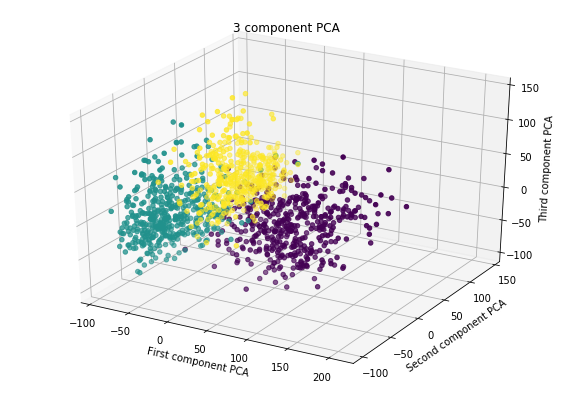

In [0]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b']
markers = ['o', 'P', 'v']
classes = np.sort(np.unique(train_label))
labels = ['grand_piano', 'sax', 'violin']

ax.scatter(training_feature_pca_3D[:, 0],
             training_feature_pca_3D[:, 1],
             training_feature_pca_3D[:, 2],
             c=train_label)

ax.set_xlabel('First component PCA')
ax.set_ylabel('Second component PCA')
ax.set_zlabel('Third component PCA')
plt.title("3 component PCA")
plt.show()

In [0]:
model = SVC(kernel ='rbf', gamma='scale', C = 1)

### SVM Classifier + T-SNE 2D

In [0]:
# Training 
model.fit(training_feature_tsne_2D, train_label)

# Evaluation
y_pred = model.predict(test_feature_tsne_2D)

# Result
acc = accuracy_score(test_label, y_pred)
print("Accuracy: {:.2f}".format(acc*100))

Accuracy: 94.00


### SVM Classifier + T-SNE 3D

In [0]:
# Training 
model.fit(training_feature_tsne_3D, train_label)

# Evaluation
y_pred = model.predict(test_feature_tsne_3D)

# Result
acc = accuracy_score(test_label, y_pred)
print("Accuracy: {:.2f}".format(acc*100))

Accuracy: 89.33


In [0]:
model = SVC(kernel ='linear', C = 1)

### SVM Classifier + PCA 2D

In [0]:
# Training 
model.fit(training_feature_pca_2D, train_label)

# Evaluation
y_pred = model.predict(test_feature_pca_2D)

# Result
acc = accuracy_score(test_label, y_pred)
print("Accuracy: {:.2f}".format(acc*100))

Accuracy: 92.00


### SVM Classifier + PCA 3D

In [0]:
# Training 
model.fit(training_feature_pca_3D, train_label)

# Evaluation
y_pred = model.predict(test_feature_pca_3D)

# Result
acc = accuracy_score(test_label, y_pred)
print("Accuracy: {:.2f}".format(acc*100))

Accuracy: 92.89


# Fully Connected approach

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all convolutional DenseNet layers and train only top layers (FC)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[

In [0]:
history = model.fit(train_data, to_categorical(train_label),
                    epochs=9,
                    batch_size=32,
                    validation_data=(test_data,to_categorical(test_label)))

Train on 1350 samples, validate on 450 samples
Epoch 1/9
1350/1350 [==============================] - 264s 196ms/step - loss: 0.6194 - acc: 0.7370 - val_loss: 0.2478 - val_acc: 0.9156
Epoch 2/9
1350/1350 [==============================] - 253s 188ms/step - loss: 0.3178 - acc: 0.8748 - val_loss: 0.2314 - val_acc: 0.9111
Epoch 3/9
1350/1350 [==============================] - 253s 188ms/step - loss: 0.2753 - acc: 0.8904 - val_loss: 0.1662 - val_acc: 0.9422
Epoch 4/9
1350/1350 [==============================] - 253s 187ms/step - loss: 0.2320 - acc: 0.9104 - val_loss: 0.1859 - val_acc: 0.9267
Epoch 5/9
1350/1350 [==============================] - 254s 188ms/step - loss: 0.2181 - acc: 0.9163 - val_loss: 0.1360 - val_acc: 0.9556
Epoch 6/9
1350/1350 [==============================] - 252s 187ms/step - loss: 0.1811 - acc: 0.9326 - val_loss: 0.2062 - val_acc: 0.9311
Epoch 7/9
1350/1350 [==============================] - 253s 187ms/step - loss: 0.1746 - acc: 0.9259 - val_loss: 0.3280 - val_acc: 0

### Results

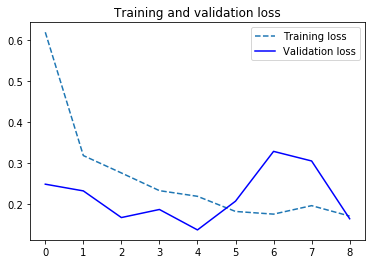

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

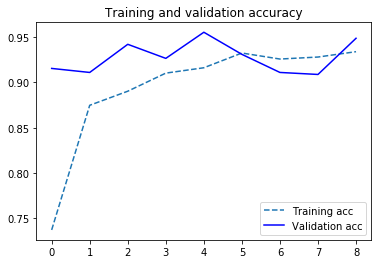

In [0]:
plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### Which photos of test dataset were misclassified?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


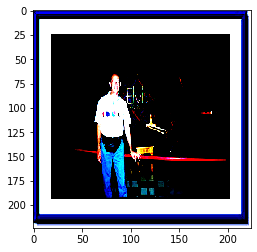

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: ground truth: 0  prediction: 1


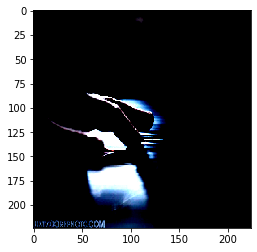

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13: ground truth: 0  prediction: 2


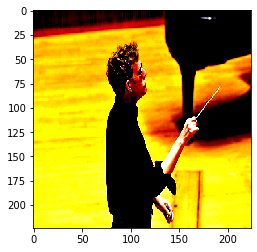

16: ground truth: 0  prediction: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


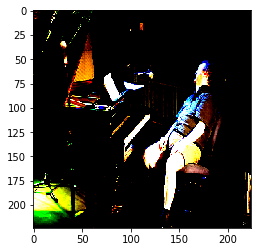

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23: ground truth: 0  prediction: 1


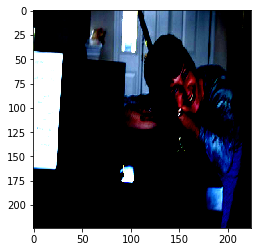

54: ground truth: 0  prediction: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


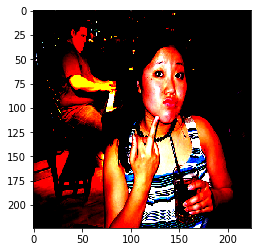

65: ground truth: 0  prediction: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


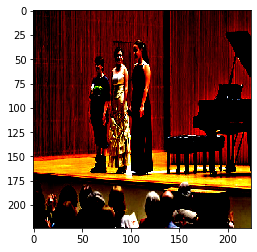

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68: ground truth: 0  prediction: 1


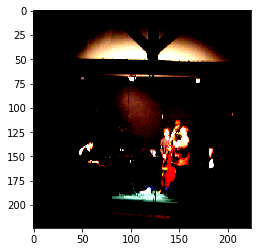

173: ground truth: 1  prediction: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


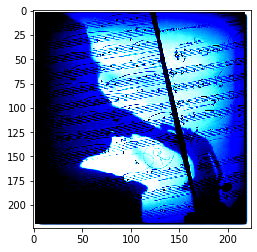

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


194: ground truth: 1  prediction: 2


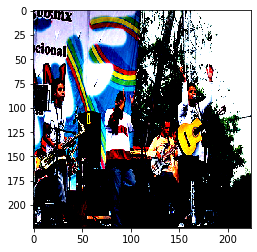

224: ground truth: 1  prediction: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


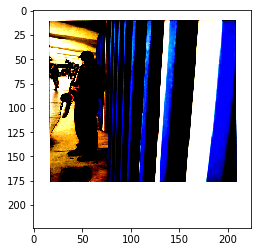

229: ground truth: 1  prediction: 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


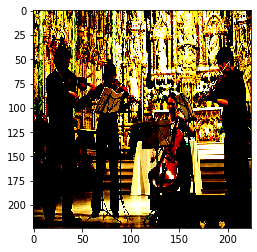

305: ground truth: 2  prediction: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


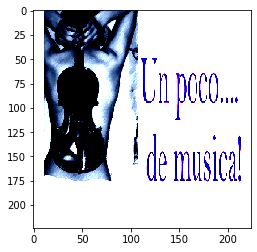

324: ground truth: 2  prediction: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


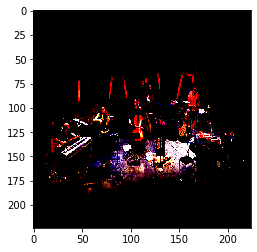

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


351: ground truth: 2  prediction: 1


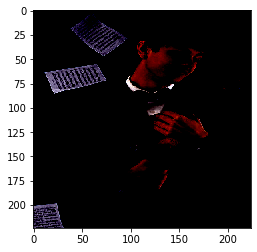

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


353: ground truth: 2  prediction: 1


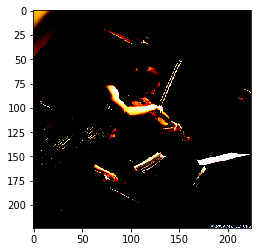

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


360: ground truth: 2  prediction: 1


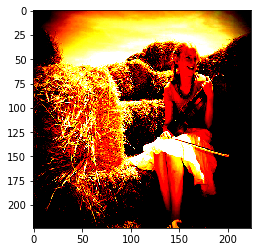

370: ground truth: 2  prediction: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


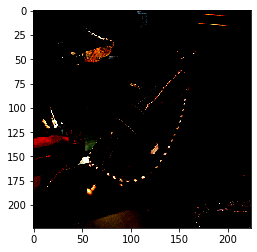

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


389: ground truth: 2  prediction: 0


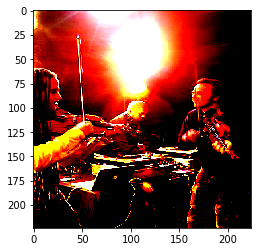

395: ground truth: 2  prediction: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


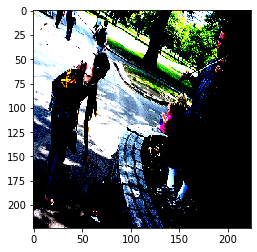

404: ground truth: 2  prediction: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


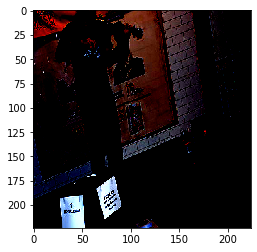

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


426: ground truth: 2  prediction: 1


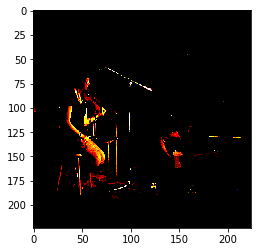

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


433: ground truth: 2  prediction: 1


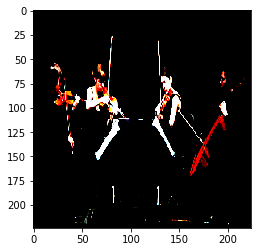

442: ground truth: 2  prediction: 1


In [0]:
probs = model.predict(test_data)
preds = np.argmax(probs,1)
wrong_predictions = np.where(preds != test_label)[0]

for i in wrong_predictions:
  plt.imshow(test_data[i])
  plt.show()
  print("{}: ground truth: {}  prediction: {}".format(i, test_label[i], preds[i]))

## Ranking

<table style="width:100%">
  <tr>
    <th>Rank</th>
    <th>Classifier</th>
    <th>Dimensionality reduction</th>
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Fully Connected</td>
    <td>-</td>
    <td bgcolor="#cedc00">95.56</td>
  </tr>
  <tr>
    <td>2</td>
    <td>SVM with RBF kernel</td>
    <td>T-SNE 2-d</td>
    <td>94.00</td>
  </tr>
  <tr>
    <td>3</td>
    <td>SVM with Linear kernel</td>
    <td>PCA 3-d</td>
    <td>92.89</td>
  </tr>
    <tr>
    <td>4</td>
    <td>SVM with Linear kernel</td>
    <td>PCA 2-d</td>
    <td>92.00</td>
  </tr>
    <tr>
    <td>5</td>
    <td>SVM with RBF kernel</td>
    <td>T-SNE 3-d</td>
    <td>89.33</td>
  </tr>
</table>